![Py4Eng](img/logo.png)

# Cython and Numba
## Yoav Ram

# Cython at a glance

[Cython](http://docs.cython.org/src/userguide/numpy_tutorial.html#cython-at-a-glance) is a compiler which compiles Python-like code files to C code. Still, ‘’Cython is not a Python to C translator’‘. That is, it doesn’t take your full program and “turns it into C” – rather, the result makes full use of the Python runtime environment. A way of looking at it may be that your code is still Python in that it runs within the Python runtime environment, but rather than compiling to interpreted Python bytecode one compiles to native machine code (but with the addition of extra syntax for easy embedding of faster C-like code).

This has two important consequences:

- **Speed.** How much depends very much on the program involved though. Typical Python numerical programs would tend to gain very little as most time is spent in lower-level C that is used in a high-level fashion. However for-loop-style programs can gain many orders of magnitude, when typing information is added (and is so made possible as a realistic alternative).
- **Easy calling into C code.** One of Cython’s purposes is to allow easy wrapping of C libraries. When writing code in Cython you can call into C code as easily as into Python code.

Some Python constructs are not yet supported, though making Cython compile all Python code is a stated goal (among the more important omissions are inner functions and generator functions).

# Hello world!

Let's start with a simple *Hello World!* to check that everything is working.

We load the `Cython` magic that will allow us to quickly use Cython inside the notebook. The magic is installed with the `cython` package (`conda install cython` or `pip install cython`). The Cython requires that a C compiler is installed and can be found, and on Windows that may be tricky, here are some resources:

- [Install Cython on Windows](https://github.com/cython/cython/wiki/InstallingOnWindows)
- [Install C compiler on Windows](https://github.com/cython/cython/wiki/CythonExtensionsOnWindows)
- [Compiling Python extensions on Windows](https://blog.ionelmc.ro/2014/12/21/compiling-python-extensions-on-windows/)

On Linux/OSX you probably already have a compiler, check with `!gcc --version`. If `gcc` is not found, install it:

- On [Ubuntu](https://help.ubuntu.com/community/InstallingCompilers) you should run `sudo apt-get install build-essential`.
- On CentOS you just need to install development tools: `sudo yum group install "Development Tools"`.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys, os

import Cython
print("Cython", Cython.__version__)

%load_ext Cython

Cython 0.29.21


In [3]:
%%cython 
print("Hello World!")

Hello World!


# First Cython example

Let's see a quick example of what Cython can do for us. 

Consider the following Python [function that returns the first k prime numbers](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html) (but not more than 1000):

In [4]:
def find_k_primes(k):
    primes = [None] * 1000
    n_primes = 0  # the current number of elements in p
    candidate = 2
    while n_primes < min(k, 1000):
        # is candidate prime?
        for p in primes[:n_primes]:
            if candidate % p == 0:
                break # not a prime        
        else: # if no break occurred in the loop, we have a prime
            primes[n_primes] = candidate
            n_primes += 1
        candidate += 1

    return primes[:n_primes]

In [5]:
assert find_k_primes(10) == [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

Here is the Cython version of this function; the only addition here is that we use `cdef` to define the types of `n, k, i, p`. This `cdef` statement is used to define **local C variables**. We also add `int` in the arguments list to define the type of `kmax`: this means that any object passed will be **converted to a C integer**.

In [6]:
%%cython
def cfind_k_primes(int k):
    cdef int n_primes, candidate, p
    cdef int[1000] primes
    n_primes = 0  # the current number of elements in p
    candidate = 2
    while n_primes < min(k, 1000):
        # is candidate prime?
        for p in primes[:n_primes]:
            if candidate % p == 0:
                break # not a prime        
        else: # if no break occurred in the loop, we have a prime
            primes[n_primes] = candidate
            n_primes += 1
        candidate += 1

    # convert primes from a cython type to a python list
    return [p for p in primes[:n_primes]] 

In [7]:
find_k_primes(100) == cfind_k_primes(100)

True

In [8]:
n = 1000
%timeit find_k_primes(n)
%timeit cfind_k_primes(n)

30.9 ms ± 525 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.1 ms ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Note that in the inner loop, only variables with type definitions, and thus C objects, are reffered to; therefore, the loop is translated to a C loop, and runs very fast.

# Creating a Cython module

We can now put that Cython code into a separate file with extension `pyx`. 

In [9]:
!mkdir ../scripts/cython
%cd ../scripts/cython

mkdir: ../scripts/cython: File exists
/Users/yoavram/Work/Teaching/Py4Eng/scripts/cython


In [10]:
%%file primes.pyx
def cfind_k_primes(int k):
    cdef int n_primes, candidate, p
    cdef int[1000] primes
    n_primes = 0  # the current number of elements in p
    candidate = 2
    while n_primes < min(k, 1000):
        # is candidate prime?
        for p in primes[:n_primes]:
            if candidate % p == 0:
                break # not a prime        
        else: # if no break occurred in the loop, we have a prime
            primes[n_primes] = candidate
            n_primes += 1
        candidate += 1

    # convert primes from a cython type to a python list
    return [p for p in primes[:n_primes]] 

Overwriting primes.pyx


Now we compile it and import it with a single stroke using the [`pyximport` module](http://docs.cython.org/en/latest/src/reference/compilation.html#pyximport),

> Cython code, unlike Python, must be compiled.
> This happens in two stages:
> A .pyx file is compiles by Cython to a .c file.
> The .c file is compiled by a C comiler to a .so file (or a .pyd file on Windows)

In [11]:
import pyximport
pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x7ffcdb0645f8>)

In [12]:
from primes import cfind_k_primes

In [13]:
len(cfind_k_primes(100)) == 100

True

You can also do this on your own, without `pyximport`. This is useful when shipping or if you just want to see the C file - for example, to see how much work Cython saved you from doing!

You start by writing a `setup.py` file which imports `cythonize` from the Cython package and tells `setup` (the standard way to setup Python packages, using `distutils` or `setuptools`) to build an extension module using `cythonize`.

In [14]:
%%file setup.py
from distutils.core import setup
from Cython.Build import cythonize

setup(
    ext_modules = cythonize("primes.pyx")
)

Overwriting setup.py


Run it with this command, which builds the extension:

In [15]:
python = os.path.join(sys.base_prefix, 'bin', 'python')
!$python setup.py build_ext --inplace

Compiling primes.pyx because it changed.
[1/1] Cythonizing primes.pyx
/Users/yoavram/miniconda3/envs/DataSciPy/lib/python3.6/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/yoavram/Work/Teaching/Py4Eng/scripts/cython/primes.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'primes' extension
creating build/temp.macosx-10.7-x86_64-3.6
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/yoavram/miniconda3/envs/DataSciPy/include -arch x86_64 -I/Users/yoavram/miniconda3/envs/DataSciPy/include -arch x86_64 -I/Users/yoavram/miniconda3/envs/DataSciPy/include/python3.6m -c primes.c -o build/temp.macosx-10.7-x86_64-3.6/primes.o
gcc -bundle -undefined dynamic_lookup -L/Users/yoavram/miniconda3/envs/DataSciPy/lib -arch x86_64 -L/Users/yoavram/miniconda3/envs/DataSciPy/lib -arch

Let's see what was generated (this might look different on different machines, especially Windows vs. Linux):

In [16]:
%ls

build/                        primes.pyx
primes.c                      setup.py
primes.cpython-36m-darwin.so* tmp/


And the actual C file:

In [17]:
%less primes.c

/* Generated by Cython 0.29.21 */

/* BEGIN: Cython Metadata
{
    "distutils": {
        "name": "primes",
        "sources": [
            "primes.pyx"
        ]
    },
    "module_name": "primes"
}
END: Cython Metadata */

#define PY_SSIZE_T_CLEAN
#include "Python.h"
#ifndef Py_PYTHON_H
    #error Python headers needed to compile C extensions, please install development version of Python.
#elif PY_VERSION_HEX < 0x02060000 || (0x03000000 <= PY_VERSION_HEX && PY_VERSION_HEX < 0x03030000)
    #error Cython requires Python 2.6+ or Python 3.3+.
#else
#define CYTHON_ABI "0_29_21"
#define CYTHON_HEX_VERSION 0x001D15F0
#define CYTHON_FUTURE_DIVISION 0
#include <stddef.h>
#ifndef offsetof
  #define offsetof(type, member) ( (size_t) & ((type*)0) -> member )
#endif
#if !defined(WIN32) && !defined(MS_WINDOWS)
  #ifndef __stdcall
    #define __stdcall
  #endif
  #ifndef __cdecl
    #define __cdecl
  #endif
  #ifndef __fastcall
    #define __fastcall
  #endif
#endif
#ifndef DL_IMPORT
  #define DL

You can now import `primes` as if it was a regular Python module (if you aren't sure which of the things you are importing, restart your kernel, but don't forger to change directory to `../scripts/cython`).

In [18]:
import primes

In [19]:
primes.cfind_k_primes(10)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

# Example - integration

This is from Robert Bradshaw [SciPy 2008 slides](http://wiki.sagemath.org/scipy08?action=AttachFile&do=get&target=scipy-cython.tgz).

We will write a simple integration code to integrate $f(x) = x^3 - 3x$:

In [20]:
def f(x):
    return x**3 - 3 * x

def integrate_f(a , b , N):
    s = 0
    dx = (b - a )/ N
    for i in range(N):
        s += f(a + i * dx)
    return s * dx

In [21]:
%timeit integrate_f(0, 1, 100000)

23 ms ± 701 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now, the same with Cython. Note that when we define a function with `cdef` we can set a return value but we can only c
all it from within Cython. When we define a function with `def` we can import it and call it from Python.

Note that we change `x**3` to `x * x * x`.

In [22]:
%%cython
cdef double g(double x):
    return x * x * x - 3* x

def integrate_g(double a , double  b , int N):
    cdef double s = 0
    cdef double dx = (b - a )/ N
    cdef int i
    for i in range(N):
        s += g( a + i * dx )
    return s * dx

In [23]:
%timeit integrate_g(0, 1, 100000)

127 µs ± 1.84 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Now let's integrate 
$$
\int_a^b{\frac{\sin{x}}{x}}
$$

Without Cython, we should use either `math.sin` or `numpy.sin`:

In [24]:
def f(x):
    return np.sin(x) / x

integrate_f(1, 2, 100000)

0.6593318405457452

With Cython, we can import some C functions using an `extern` block:

In [25]:
%%cython
cdef extern from "math.h":
    double sin(double)
    double cos(double)

cdef double g(double x):
    return sin(x)/x

def integrate_g(double a , double  b , int N):
    cdef double s = 0
    cdef double dx = (b - a) /  N
    cdef int i
    for i in range(N):
        s += g(a + i * dx)
    return s * dx

In [26]:
%timeit integrate_f(1, 3, 100000)
%timeit integrate_g(1, 3, 100000)

118 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
975 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Cython + NumPy

Cython works well with NumPy.

Let's loop over a NumPy array:

In [27]:
def summ(x):
    s = 0
    for i in range(x.shape[0]):
        s += x[i]
    return s

In [35]:
%%cython
cimport numpy as np

def csumm(long[:] x): # input type is a buffer
    cdef int i = 0
    cdef long s = 0
    cdef Py_ssize_t size = x.shape[0]
    for i in range(size):
        s += x[i]
    return s

In [36]:
x = np.random.randint(0, 9, 100000)
%timeit summ(x)
%timeit csumm(x)

19.2 ms ± 681 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
117 µs ± 683 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Note that if you would type `s` and `arr` as made of `int` you would get an error because Python's `int` is a C `long`... But you would get a `ValueError`, not a segmentation fault or anything like that. Here's an example:

In [37]:
y = np.array([0.1, 0.2, 0.3])
csumm(y)

ValueError: Buffer dtype mismatch, expected 'long' but got 'double'

# Example - Mandelbrot fractal

In [38]:
import numpy as np

def mandelbrot(m, size, iterations):    
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

In [39]:
%%cython
def cmandelbrot(int[:,:] m,
                int size,
                int iterations):
    cdef int i, j, n
    cdef complex z, c
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if z.real**2 + z.imag**2 <= 100: # note - no use of np.abs
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

In [40]:
size = 200
iterations = 100
m = np.zeros((size, size), dtype=np.int32)

In [41]:
%timeit mandelbrot(m, size, iterations)
%timeit cmandelbrot(m, size, iterations)

1.5 s ± 38.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.56 ms ± 81.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


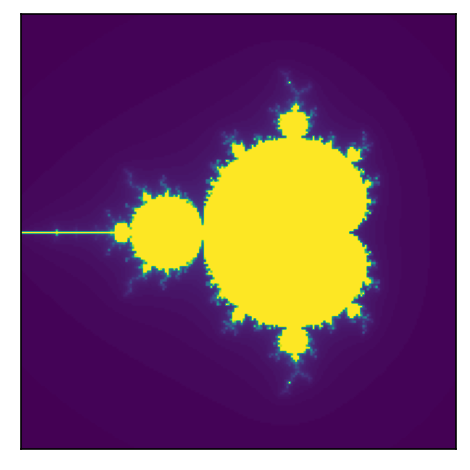

In [42]:
mandelbrot(m, size, iterations)
plt.imshow(m, cmap='viridis')
plt.xticks([])
plt.yticks([]);

# Exercise - difference matrix

Write a Cython function that calculates the difference matrix for a given array.
Compare it to the NumPy implementation.

In [10]:
def diff_mat(x):
    return x.reshape(-1, 1) - x

In [95]:
x = np.random.random(10000)
assert np.allclose(diff_mat(x), cdiff_mat(x))
%timeit diff_mat(x)
%timeit cdiff_mat(x)

455 ms ± 27.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
496 ms ± 25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


You can explore other [compiler directives](https://github.com/cython/cython/wiki/enhancements-compilerdirectives) such as `wraparound` and `nonecheck`.

# Numba

[Numba]((http://numba.pydata.org) speeds functions written directly in Python. 
With a few annotations, array-oriented and math-heavy Python code can be *just-in-time* (JIT) compiled to native machine instructions, similar in performance to C, C++ and Fortran, without having to switch languages or Python interpreters.

Roughly, [JIT](https://en.wikipedia.org/wiki/Just-in-time_compilation) compilation combines the speed of compiled code with the flexibility of interpretation, with the overhead of an interpreter and the additional overhead of compiling (not just interpreting).

Numba also allows to release the GIL, thus allowing multithreading in CPU-bounded applications; it also allows to automatically parallelize code - see details in a [blog post](https://www.anaconda.com/blog/developer-blog/parallel-python-with-numba-and-parallelaccelerator/) by Anaconda.

In [43]:
import numba
print('Numba', numba.__version__)

Numba 0.51.2


In [44]:
@numba.jit()
def numandelbrot(m, size, iterations):    
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
numandelbrot(m, size, iterations); # run once for jit to work

In [45]:
size = 1000
iterations = 1000
m = np.zeros((size, size), dtype=np.int32)

# %timeit mandelbrot(m, size, iterations)
%timeit cmandelbrot(m, size, iterations)
%timeit numandelbrot(m, size, iterations)

749 ms ± 8.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.05 s ± 7.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Exercise - Numba

Consider the following NumPy function which calculates the mean squared error of two arrays/

In [46]:
def mean_squared_error_np(yhat, y):
    return ((yhat - y)**2).mean()

Write a pure-Python version of this function, then JIT it with Numba.

In [ ]:
def mean_squared_error_py(yhat, y):
    pass

def mean_squared_error_nm(yhat, y):
    pass

In [18]:
n = 100000
y = np.random.random(n)
yhat = np.random.random(n)
%timeit mean_squared_error_np(yhat, y)
%timeit mean_squared_error_py(yhat, y)
%timeit mean_squared_error_nm(yhat, y)

148 µs ± 17.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
60.3 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
118 µs ± 3.86 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Releasing the GIL

Cython can be directed to [release the GIL](http://docs.cython.org/src/userguide/external_C_code.html#acquiring-and-releasing-the-gil), thus enabling multiple threads to run in parallel (if the OS allows it) and achieve performence gain even in comparison to multi-processing, as threads are cheaper than processes and thread communication is faster than process communication.

In [47]:
def display_image(im):
    plt.imshow(im, cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [55]:
%pwd

'/Users/yoavram/Work/Teaching/Py4Eng/sessions'

Let's do a segmentation demonstration.

(dtype('float64'), (600, 629), 0.0, 255.0)

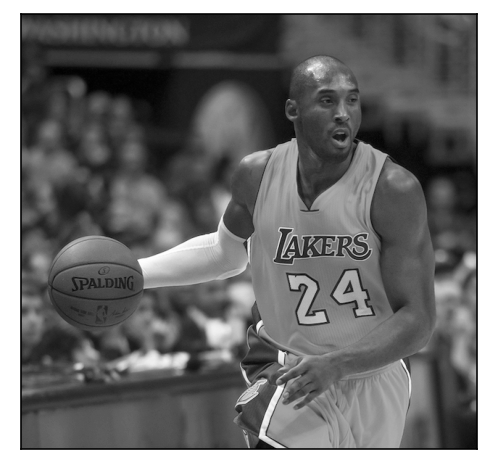

In [56]:
# original image from https://upload.wikimedia.org/wikipedia/commons/5/56/Kobe_Bryant_2014.jpg
import imageio
image = imageio.imread('../data/Kobe_Bryant_2014.jpg')
image = image.mean(axis=2) # greyscale
display_image(image)
image.dtype, image.shape, image.min(), image.max()

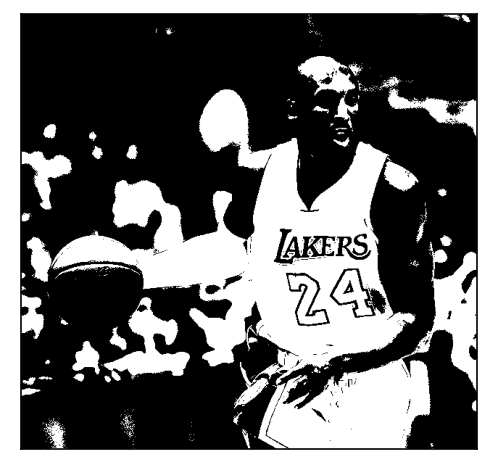

In [57]:
def segment(image, threshold):
    output = np.zeros_like(image)
    output[image > threshold] = 255
    return output

display_image(segment(image, 100))

## Cython no-gil

In [58]:
%%cython
import numpy as np
import cython 

# if you comment this out, cython will warn you to add it for faster access
@cython.boundscheck(False) 
cdef void _segment(double[:,:] image, int n, int m, 
                   double threshold, double[:,:] output) nogil: # note the "nogil" directive
    cdef int i, j
    for i in range(n):
        for j in range(m):
            if image[i, j] > threshold:
                output[i, j] = 255
            else:
                output[i, j] = 0

def csegment(image, threshold):
    output = np.zeros_like(image)
    n, m = image.shape
    _segment(image, n , m, threshold, output)
    return output

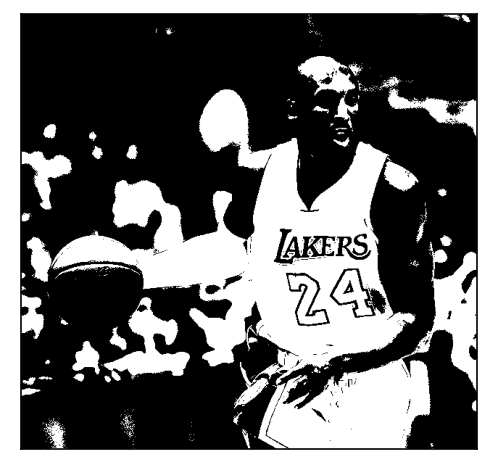

In [59]:
display_image(csegment(image, 100))

In [60]:
%timeit segment(image, 100)
%timeit csegment(image, 100)

603 µs ± 45.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
311 µs ± 23.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


So performance on a single image is similar, what about using multi-threading for segmenting a bunch of images?

Let's download the 30 examples images from the [Berkeley Segmentation Dataset](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/dataset/images/color/test-001-025.html).

![example](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/295087.jpg)

In [66]:
image_urls = [
    'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/{:d}.jpg'.format(i)
    for i in [119082,170057,58060,163085,42049,167062,157055,295087,24077,78004,220075,45096,38092,43074,16077,86000,101085,219090,89072,300091,126007,156065,76053,296007,175032]
]
image_urls[0]

'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/119082.jpg'

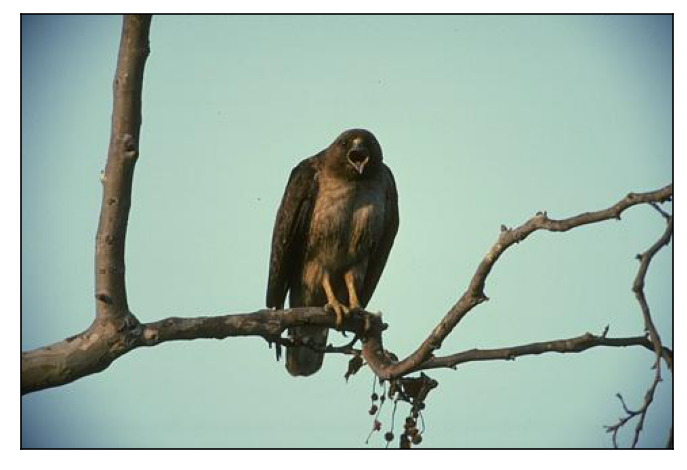

In [67]:
display_image(imageio.imread(image_urls[4]))

Let's load and flatten the images:

In [68]:
images = [imageio.imread(url) for url in image_urls]
images = [im.mean(axis=2) for im in images]

Let's also resize the images so that the segmentation task is computationaly harder.

In [71]:
from skimage.transform import resize

In [70]:
shapes = [im.shape for im in images]
images = [resize(im, (w*12, h*12), mode='reflect') 
          for im, (w, h) in zip(images, shapes)]

First compare the NumPy and Cython versions:

In [75]:
%time [segment(im, 100) for im in images]
%time [csegment(im, 100) for im in images]
;

CPU times: user 2.03 s, sys: 1.69 s, total: 3.72 s
Wall time: 4.53 s
CPU times: user 1.65 s, sys: 1.95 s, total: 3.59 s
Wall time: 4.07 s


''

No real difference, of course.
Now let's do it with multi-threading, leveraging the `nogil` directive.

In [76]:
from concurrent.futures import ThreadPoolExecutor

def segment_parallel(images, threshold):
    def _segment(im):
        return csegment(im, threshold)
    
    with ThreadPoolExecutor() as executor:
        results = executor.map(_segment, images)
        return list(results)

In [77]:
%time [csegment(im, 100) for im in images]
%time segment_parallel(images, 100)
;

CPU times: user 1.45 s, sys: 1.38 s, total: 2.83 s
Wall time: 2.88 s
CPU times: user 1.74 s, sys: 1.96 s, total: 3.69 s
Wall time: 1.01 s


''

You can look at the process monitor (or `top`/`htop` on Linux/Mac) when the next two cells run to see that the first uses less cores than the latter. 

In [ ]:
for _ in range(10): 
    [csegment(im, 100) for im in images];

In [57]:
for _ in range(10): 
    segment_parallel(images, 100);

## Numba no-gil

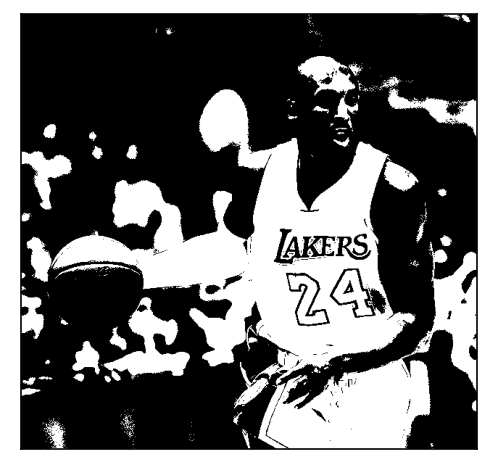

In [78]:
@numba.jit(nopython=True, nogil=True)
def _nmsegment(image, threshold, output):
    n, m = image.shape
    for i in range(n):
        for j in range(m):
            if image[i, j] > threshold:
                output[i, j] = 255
            else:
                output[i, j] = 0
    return output

def nmsegment(image, threshold):
    output = np.empty_like(image)
    _nmsegment(image, threshold, output)
    return output

display_image(nmsegment(image, 100))

In [79]:
%time segment(images[0], 100)
%time csegment(images[0], 100)
%time nmsegment(images[0], 100)
;

CPU times: user 71.1 ms, sys: 49.9 ms, total: 121 ms
Wall time: 120 ms
CPU times: user 52.2 ms, sys: 37.7 ms, total: 89.9 ms
Wall time: 89.9 ms
CPU times: user 39.5 ms, sys: 42.1 ms, total: 81.6 ms
Wall time: 81 ms


''

In [80]:
from concurrent.futures import ThreadPoolExecutor

def segment_parallel(images, threshold):  
    def func(image):
            return nmsegment(image, threshold)
    
    with ThreadPoolExecutor() as executor:        
        results = executor.map(func, images)
        return list(results)

In [81]:
%time [nmsegment(im, 100) for im in images]
%time segment_parallel(images, 100)
;

CPU times: user 963 ms, sys: 1.07 s, total: 2.03 s
Wall time: 2.3 s
CPU times: user 1.43 s, sys: 2.37 s, total: 3.8 s
Wall time: 693 ms


''

# Numba automatic parallelization

Numba uses Intel's MKL to automate parallelization of for loops with multiple threads.

Consider the function for calculation of MSE:

In [82]:
@numba.jit
def mean_squared_error_nm(yhat, y):
    mse = 0
    n = len(y)
    for i in range(n):
        mse += (yhat[i] - y[i])**2
    mse /= n
    return mse

We can parallelize it by adding the `parallel=True` directive (which requires that we can set `nopython=True` without getting an error) and using `numba.prange` instead of `range`:

In [83]:
@numba.jit(parallel=True, nopython=True)
def mean_squared_error_pr(yhat, y):
    mse = 0
    n = len(y)
    for i in numba.prange(n):
        mse += (yhat[i] - y[i])**2
    mse /= n
    return mse

In [84]:
n = 1000000
y = np.random.random(n)
yhat = np.random.random(n)
%timeit mean_squared_error_nm(yhat, y)
%timeit mean_squared_error_pr(yhat, y)

1.46 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
303 µs ± 59.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Roughly four-fold faster - which makes sense on my 4-CPU machine.

# Numba stencils (local filters)

Numba's `stencil` decorator works similar to SciPy's `generic_filter`, but uses the JIT capabilities of Numba.

Let's start by adding some noise to the images:

In [85]:
def salt_pepper(image, p=0.01):
    """Generates salt and pepper noise.
    
    Each pixel is "hit" independently with probability `p`. 
    If hit, a pixel has 1:1 chance of becoming white or black.
    """
    noisy = image.copy()
    rand = np.random.random(size=noisy.shape)
    mask_black = rand <= p/2
    noisy[mask_black] = 0
    mask_white = (p/2 < rand) & (rand <= p)
    noisy[mask_white] = 255
    return noisy

In [86]:
noisy = [salt_pepper(im, p=0.25) for im in images]

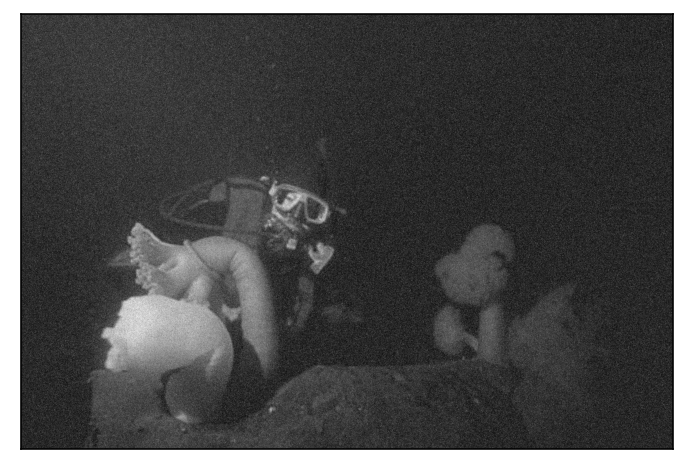

In [93]:
display_image(noisy[11])

Now let's clean the images with a bounded mean filter.

We write a function that accepts a 2D neighborhood, the dimensions of which can be specified in the `stencil` directive, and return the stencil (i.e. local filter) result.
The `stencil` decorator does the rest.

In [88]:
k = 5
white_th=250
black_th=5

def local_bounded_mean(image, black_th, white_th, kernel_size):
    k = kernel_size
    
    @numba.stencil(neighborhood=((-k, k), (-k, k)))
    def stencil(neighbours):
        center_pixel = neighbours[0,0]
        if center_pixel < black_th or center_pixel > white_th:
            acc, cnt = 0, 0
            for i in range(-k, k+1):
                for j in range(-k, k+1):
                    pixel = neighbours[i,j]
                    if pixel >= black_th and pixel <= white_th:
                        acc += pixel
                        cnt += 1
            if cnt > 0:
                return acc / cnt
        return center_pixel
    
    return stencil(image)

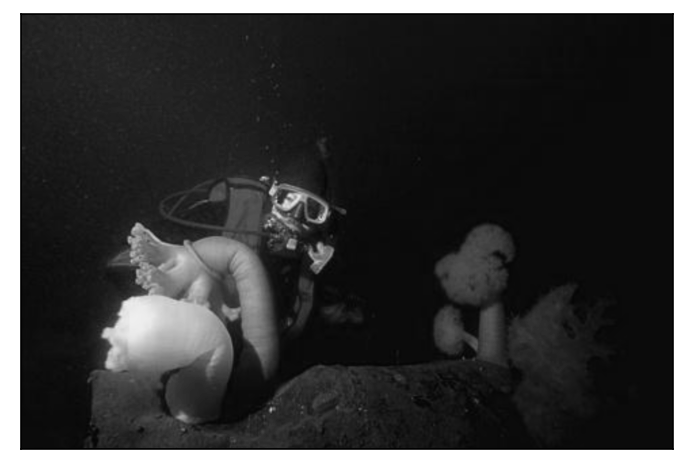

In [94]:
display_image(local_bounded_mean(noisy[11], 5, 250, k))

Compare this with the SciPy version:

In [95]:
from scipy.ndimage import generic_filter

def local_bounded_mean2(image, black_th, white_th, kernel_size):
    n = 2*kernel_size+1
    def stencil(neighbours):
        center = neighbours.size // 2
        center_pixel = neighbours[center]
        if center_pixel < black_th or center_pixel > white_th:
            mask = (black_th <= neighbours) & (neighbours <= white_th)
            if mask.any():
                return neighbours[mask].mean()
        # either center was not extreme or all its neighbors are extreme
        return center_pixel

    return generic_filter(image, stencil, size=(n, n))

In [96]:
%time local_bounded_mean(noisy[0], 5, 250, k)
%time local_bounded_mean2(noisy[0], 5, 250, k)
;

CPU times: user 1.83 s, sys: 150 ms, total: 1.98 s
Wall time: 2 s
CPU times: user 1min 35s, sys: 2.71 s, total: 1min 38s
Wall time: 1min 46s


''

# Solutions

Difference Matrix:

In [ ]:
%%cython
cimport numpy as np
import numpy as np
import cython        
        
cdef void _cdiff_mat(double[:] x, int size, double[:,:] output):
    cdef int i, j
    for i in range(size):
        for j in range(size):
            output[i, j] = x[i] - x[j]        

def cdiff_mat(double[:] x):
    size = len(x)
    output = np.empty((size, size))
    _cdiff_mat2(x, size, output)
    return output

Mean squared error:

In [3]:
def mean_squared_error_py(yhat, y):
    mse = 0
    n = len(y)
    for i in range(n):
        mse += (yhat[i] - y[i])**2
    mse /= n
    return mse

In [4]:
mean_squared_error_nm = numba.jit(mean_squared_error_py)

In [9]:
@numba.jit(parallel=True, nopython=True)
def mean_squared_error_pr(yhat, y):
    mse = 0
    n = len(y)
    for i in numba.prange(n):
        mse += (yhat[i] - y[i])**2
    mse /= n
    return mse

In [10]:
n = 100000
y = np.random.random(n)
yhat = np.random.random(n)
%timeit mean_squared_error_np(yhat, y)
%timeit mean_squared_error_py(yhat, y)
%timeit mean_squared_error_nm(yhat, y)
%timeit mean_squared_error_pr(yhat, y)

122 µs ± 3.67 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
51.9 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
114 µs ± 813 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
62.7 µs ± 1.43 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# References

- [Cython language basics](http://docs.cython.org/src/userguide/language_basics.html#language-basics)
- [Cython for NumPy users](http://docs.cython.org/src/userguide/numpy_tutorial.html#numpy-tutorial) offers a 2D convolve example.
- [IPython Cookbook](https://ipython-books.github.io/cookbook/) by Cyrille Rossant has a full chapter on high performance computing. with many [notebook examples](https://github.com/ipython-books/cookbook-code/tree/master/notebooks/chapter05_hpc) and a more complicated Cython example.
- [Numba](http://numba.pydata.org/)
- [Parallelization with Numba](https://www.anaconda.com/blog/developer-blog/parallel-python-with-numba-and-parallelaccelerator/)
- [Numexpr](https://github.com/pydata/numexpr/wiki/Numexpr-Users-Guide)
- [Blaze Ecosystem](http://blaze.pydata.org/)
- Jake Vanderplas's [Cython project template](https://github.com/jakevdp/cython_template) can help you build projects that use Cython.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.6.1.
Dependencies listed in [environment.yml](../environment.yml), full versions in [environment_full.yml](../environment_full.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)